In [ ]:
!pip install pandas openpyxl

# BATAS

In [ ]:
import pandas as pd
import random
import numpy as np

# Load data
mata_kuliah_df = pd.read_excel('ujian ganjil.xlsx', sheet_name='Mata Kuliah')
pengawas1_df = pd.read_excel('ujian ganjil.xlsx', sheet_name='Pengawas1')
pengawas2_df = pd.read_excel('ujian ganjil.xlsx', sheet_name='Pengawas2')
ruangan_df = pd.read_excel('ujian ganjil.xlsx', sheet_name='Ruangan')
hari_df = pd.read_excel('ujian ganjil.xlsx', sheet_name='Hari')
sesi_df = pd.read_excel('ujian ganjil.xlsx', sheet_name='Sesi')

# Siapkan list dari DataFrame
daftar_mk       = mata_kuliah_df[['Mata Kuliah', 'Kelas']].apply(tuple, axis=1).tolist()
daftar_ruangan  = ruangan_df['Ruangan'].unique().tolist()
daftar_pengawas1 = pengawas1_df['Pengampu'].unique().tolist()
daftar_pengawas2 = pengawas2_df['Tendik'].unique().tolist()
daftar_hari     = hari_df['Hari'].tolist()
daftar_sesi     = sesi_df['Sesi'].tolist()

In [ ]:
def generate_schedule(daftar_mk, daftar_pengawas1, daftar_pengawas2, daftar_ruangan, daftar_hari, daftar_sesi):
    total_slot = len(daftar_hari) * len(daftar_sesi) * len(daftar_ruangan)

    # Jika jumlah MK kurang dari slot, tambahkan slot kosong (None)
    kumpulan_mk = daftar_mk.copy()
    random.shuffle(kumpulan_mk)
    while len(kumpulan_mk) < total_slot:
        kumpulan_mk.append((None, None))  # Slot kosong

    # Pastikan panjangnya sama dengan total_slot
    kumpulan_mk = kumpulan_mk[:total_slot]

    jadwal = []
    index = 0

    for hari in daftar_hari:
        for sesi in daftar_sesi:
            for ruangan in daftar_ruangan:
                mk, kelas = kumpulan_mk[index]
                pengawas1 = random.choice(daftar_pengawas1) if mk is not None else None
                pengawas2 = random.choice(daftar_pengawas2) if mk is not None else None

                if mk is not None:
                    # Append both pengawas1 and pengawas2
                    jadwal.append([hari, sesi, mk, kelas, ruangan, pengawas1, pengawas2])
                else:
                     # For empty slots, still append 7 elements (with None for pengawas)
                    jadwal.append([hari, sesi, mk, kelas, ruangan, pengawas1, pengawas2])

                index += 1

    data_df = pd.DataFrame(jadwal, columns=['Hari', 'Sesi', 'Mata Kuliah', 'Kelas', 'Ruangan', 'Pengawas 1', 'Pengawas 2'])
    return data_df

In [ ]:
data_df = generate_schedule(daftar_mk, daftar_pengawas1, daftar_pengawas2, daftar_ruangan, daftar_hari, daftar_sesi)
display(data_df)

,Hari,Sesi,Mata Kuliah,Kelas,Ruangan,Pengawas 1,Pengawas 2
0,1,1,Analisis dan Perancangan Sistem,D,F4.1,"Fariz Andri Bakhtiar, ST., M.Kom.","Edwin Ibnu Kautsar, S.Kom."
1,1,1,Jaringan Nirkabel,E,F4.2,"Arief Andy Soebroto, ST., M.Kom.","Rendra Firmansyah, SE."
2,1,1,Kalkulus,D,F4.3,"Ir. Nurudin Santoso, ST., MT.","Rezavani Fahrulloh , S.T."
3,1,1,Bahasa Indonesia,N7E,F4.4,"Sabriansyah Rizqika Akbar, S.T., M.Eng., Ph.D.","Pambayun Wulan Utami, S.Si."
4,1,1,Interaksi Manusia dan Komputer,E,F4.5,"Khalid Rahman, S.Pd.I., M.Pd.I.","Djoko Irawan, S.E."
...,...,...,...,...,...,...,...
155,4,4,Interaksi Manusia dan Komputer,C,F4.6,"Dany Primanita Kartikasari, S.T., M.Kom.","Ivan Yulfrian, S.Kom."
156,4,4,Basis Data,E,F4.7,"Dr. Ir. Lailil Muflikhah, S.Kom., M.Sc.","Nanda Galih Ardana, S.Kom."
157,4,4,Kecerdasan Artifisial,F,F4.8,"Dr. Candra Dewi, S.Kom., M.Sc.",Achmad Sholeh
158,4,4,None,None,F4.9,None,None


In [ ]:
# # Constraints dan bobot
constraints = {
    1: 0.05,
    2: 0.05,
    3: 0.05,
    4: 0.01  # soft constraint
}

In [ ]:
def calculate_cost(data_df, constraints):
    cost = 0

    df = data_df.dropna(subset=['Mata Kuliah', 'Kelas'])

    # Constraint 1: Pengawas 1 tidak boleh mengawas 2x dalam 1 hari
    df_p1 = df.dropna(subset=['Pengawas 1'])
    df_p1_group = df_p1.groupby(['Pengawas 1', 'Hari', 'Sesi']).size().reset_index(name='jumlah')
    df_p1_group = df_p1_group[df_p1_group['jumlah'] > 1]
    cost += ((df_p1_group['jumlah'] - 1) * constraints[1]).sum()

    # Constraint 2: Pengawas 2 tidak boleh mengawas 2x dalam 1 sesi
    df_p2 = df.dropna(subset=['Pengawas 2'])
    df_p2_group = df_p2.groupby(['Pengawas 2', 'Hari', 'Sesi']).size().reset_index(name='jumlah')
    df_p2_group = df_p2_group[df_p2_group['jumlah'] > 1]
    cost += ((df_p2_group['jumlah'] - 1) * constraints[2]).sum()

    # Constraint 3 (MODIFIKASI): Jumlah sesi unik per MK > 2
    sesi_unik = df.groupby(['Mata Kuliah', 'Hari', 'Sesi']).size().reset_index()
    sesi_count = sesi_unik.groupby('Mata Kuliah').size().reset_index(name='JumlahSesi')
    sesi_count = sesi_count[sesi_count['JumlahSesi'] > 2]
    cost += ((sesi_count['JumlahSesi'] - 2) * constraints[3]).sum()

    # Constraint 4: MK 1 kelas tidak seragam hari
    mk_kelas_hari = {}
    for index, row in df.iterrows():
        mk = row['Mata Kuliah']
        kelas = row['Kelas']
        hari = row['Hari']
        if mk not in mk_kelas_hari:
            mk_kelas_hari[mk] = {}
        if kelas not in mk_kelas_hari[mk]:
            mk_kelas_hari[mk][kelas] = hari
        elif mk_kelas_hari[mk][kelas] != hari:
            cost += constraints[4]

    fitness = 1 / (1 + cost)
    return cost, fitness

In [ ]:
# ---------------- Constraint 1 ----------------
def cek_bentrok_pengawas(data_df, constraints):
    """Pengawas 1 > 1× per hari"""
    df = (data_df
          .dropna(subset=['Pengawas 1'])
          .groupby(['Pengawas 1', 'Hari', 'Sesi'])
          .size()
          .reset_index(name='jumlah'))
    df = df.query('jumlah > 1').copy()
    if df.empty:
        return pd.DataFrame(columns=['Jenis', 'Hari', 'Sesi', 'Skor', 'Pengawas 1'])
    df['Skor']  = (df['jumlah'] - 1) * constraints[1]
    df['Jenis'] = 'Pengawas 1 >1×/Sesi'
    return df[['Jenis', 'Hari', 'Sesi', 'Skor', 'Pengawas 1']]

# ---------------- Constraint 2 ----------------
def cek_pengawas2_dua_kali_sesi(data_df, constraints):
    """Pengawas 2 > 1× pada kombinasi (hari, sesi)"""
    df = (data_df
          .dropna(subset=['Pengawas 2'])
          .groupby(['Pengawas 2', 'Hari', 'Sesi'])
          .size()
          .reset_index(name='jumlah'))
    df = df.query('jumlah > 1').copy()
    if df.empty:
        return pd.DataFrame(columns=['Jenis', 'Hari', 'Sesi', 'Skor', 'Pengawas 2'])
    df['Skor']  = (df['jumlah'] - 1) * constraints[2]
    df['Jenis'] = 'Pengawas 2 >1×/Sesi'
    return df[['Jenis', 'Hari', 'Sesi', 'Skor', 'Pengawas 2']]

# ---------------- Constraint 3 ----------------
def cek_mk_tidak_seragam(data_df, constraints):
    df = data_df.dropna(subset=['Mata Kuliah', 'Hari', 'Sesi']).copy()
    df_slot = df.groupby(['Mata Kuliah', 'Hari', 'Sesi']).size().reset_index(name='Jumlah Kelas')
    df_jumlah = df_slot.groupby('Mata Kuliah').size().reset_index(name='Jumlah Slot')
    df_jumlah = df_jumlah[df_jumlah['Jumlah Slot'] > 2]
    df_melanggar = df_slot[df_slot['Mata Kuliah'].isin(df_jumlah['Mata Kuliah'])].copy()

    # Gabungkan daftar slot (Hari-Sesi) ke satu kolom per MK
    df_melanggar['Slot'] = df_melanggar['Hari'].astype(str) + '-' + df_melanggar['Sesi'].astype(str)
    df_summary = df_melanggar.groupby('Mata Kuliah').agg({
        'Slot': lambda x: ', '.join(sorted(x)),
        'Jumlah Kelas': 'sum'
    }).reset_index()

    # Tambahkan skor dan info
    df_summary = df_summary.merge(df_jumlah, on='Mata Kuliah')
    df_summary['Jenis'] = 'MK Tidak Seragam'
    df_summary['Skor'] = (df_summary['Jumlah Slot'] - 2) * constraints[3]

    return df_summary[['Jenis', 'Mata Kuliah', 'Jumlah Slot', 'Slot', 'Skor']]

# ---------------- Constraint 4 ----------------
def cek_mk_kelas_hari(data_df, constraints):
    df = data_df.dropna(subset=['Mata Kuliah', 'Kelas', 'Hari', 'Sesi'])
    mk_kelas_hari = {}
    hasil = []
    for _, row in df.iterrows():
        mk, kelas, hari = row['Mata Kuliah'], row['Kelas'], row['Hari']
        if mk not in mk_kelas_hari:
            mk_kelas_hari[mk] = {}
        if kelas not in mk_kelas_hari[mk]:
            mk_kelas_hari[mk][kelas] = hari
        elif mk_kelas_hari[mk][kelas] != hari:
            hasil.append({
                'Jenis': 'MK 1 Kelas Tidak Seragam',
                'Mata Kuliah': mk,
                'Kelas': kelas,
                'Hari': hari,
                'Sesi': row['Sesi'],
                'Skor': constraints[4]
            })
    return pd.DataFrame(hasil)

def cek_semua_bentrok(data_df, constraints):
    return pd.concat([
        cek_bentrok_pengawas(data_df, constraints),     # constraint 1
        cek_pengawas2_dua_kali_sesi(data_df, constraints),  # constraint 2
        cek_mk_tidak_seragam(data_df, constraints),     # constraint 3
        cek_mk_kelas_hari(data_df, constraints)         # constraint 4
    ], ignore_index=True)


def tampilkan_jenis_pelanggaran(pelanggaran_df, jenis_pelanggaran):
    df_jenis = pelanggaran_df[pelanggaran_df['Jenis'] == jenis_pelanggaran].copy()
    if df_jenis.empty:
        print(f"✅ Tidak ada pelanggaran untuk jenis: {jenis_pelanggaran}")
        return
    df_jenis = df_jenis.dropna(axis=1, how='all')
    styled_table = df_jenis.style.set_caption(f"🚨 **Ringkasan Pelanggaran: {jenis_pelanggaran}**")\
        .background_gradient(subset=['Skor'], cmap='Reds')\
        .format({
            'Skor': '{:.2f}',
            'Jumlah Slot': '{:.0f}',
            'Hari': '{:.0f}',
            'Sesi': '{:.0f}'
            })\
        .hide(axis="index")\
        .set_table_styles([
            {'selector': 'caption', 'props': [('color', '#d32f2f'), ('font-size', '18px'), ('font-weight', 'bold')]},
            {'selector': 'table', 'props': [('border-collapse', 'collapse')]},
            {'selector': 'th', 'props': [('background-color', '#547792'), ('padding', '10px'), ('text-align', 'center'), ('font-size', '14px')]},
            {'selector': 'td', 'props': [('padding', '8px'), ('text-align', 'center')]},
        ])
    display(styled_table)

# Jalankan pengecekan
pelanggaran_df = cek_semua_bentrok(data_df, constraints)
total_cost = pelanggaran_df['Skor'].sum()
fitness = 1 / (1 + total_cost)

# Menampilkan seluruh jenis pelanggaran
jenis_list = pelanggaran_df['Jenis'].unique()
for jenis in jenis_list:
    tampilkan_jenis_pelanggaran(pelanggaran_df, jenis)

# Ringkasan akhir
print(f"\nBest Cost: {total_cost:.2f}")
print(f"Fitness: {fitness:.4f}")


Jenis,Hari,Sesi,Skor,Pengawas 1
Pengawas 1 >1×/Sesi,1,4,0.05,"Arief Andy Soebroto, ST., M.Kom."
Pengawas 1 >1×/Sesi,3,2,0.05,"Arief Andy Soebroto, ST., M.Kom."
Pengawas 1 >1×/Sesi,2,1,0.05,"Dr. Drs. Marji, M.T."
Pengawas 1 >1×/Sesi,3,1,0.05,"Eko Sakti Pramukantoro, S.Kom., M.Kom., Ph.D."
Pengawas 1 >1×/Sesi,4,2,0.05,"Ir. Adam Hendra Brata, S.Kom., M.Sc."
Pengawas 1 >1×/Sesi,3,4,0.05,"Ir. Ari Kusyanti, S.T., M.Sc."
Pengawas 1 >1×/Sesi,2,2,0.05,"Ir. Indriati, S.T., M.Kom."
Pengawas 1 >1×/Sesi,1,4,0.05,"Ir. Primantara Hari Trisnawan, M.Sc."
Pengawas 1 >1×/Sesi,2,2,0.05,"Ir. Primantara Hari Trisnawan, M.Sc."
Pengawas 1 >1×/Sesi,4,1,0.05,"Ir. Primantara Hari Trisnawan, M.Sc."


Jenis,Hari,Sesi,Skor,Pengawas 2
Pengawas 2 >1×/Sesi,3,4,0.05,Ahmad Zam Zam Almaqi
Pengawas 2 >1×/Sesi,3,1,0.05,"Dewi Wijayanti, S.T."
Pengawas 2 >1×/Sesi,3,3,0.05,Endy Rangga Prastyawan
Pengawas 2 >1×/Sesi,1,2,0.05,Ghofar Ismail
Pengawas 2 >1×/Sesi,4,1,0.05,"Gondo Suwiryo, S.Kom."
Pengawas 2 >1×/Sesi,4,2,0.05,"Hasta Budiratna, S.Sos."
Pengawas 2 >1×/Sesi,3,1,0.05,"Redy Gunawan Prasetya, S.Pt."
Pengawas 2 >1×/Sesi,1,3,0.05,"Rendra Firmansyah, SE."
Pengawas 2 >1×/Sesi,2,3,0.05,"Rieftiyan David Felani, S.E."
Pengawas 2 >1×/Sesi,2,2,0.05,"Rini, S.E."


Jenis,Skor,Mata Kuliah,Jumlah Slot,Slot
MK Tidak Seragam,0.10,Agama Islam,4,"2-2, 2-3, 3-3, 4-3"
MK Tidak Seragam,0.20,Analisis dan Perancangan Sistem,6,"1-1, 1-2, 1-3, 1-4, 2-4, 3-3"
MK Tidak Seragam,0.15,Arsitektur dan Organisasi Komputer,5,"1-3, 2-2, 2-3, 2-4, 3-3"
MK Tidak Seragam,0.15,Bahasa Indonesia,5,"1-1, 1-2, 2-3, 3-3, 4-1"
MK Tidak Seragam,0.15,Basis Data,5,"2-1, 2-3, 3-2, 4-3, 4-4"
MK Tidak Seragam,0.05,Deep Learning,3,"1-2, 1-3, 4-1"
MK Tidak Seragam,0.20,Interaksi Manusia dan Komputer,6,"1-1, 2-3, 3-1, 3-4, 4-2, 4-4"
MK Tidak Seragam,0.20,Jaringan Komputer,6,"1-1, 2-3, 2-4, 3-2, 3-4, 4-3"
MK Tidak Seragam,0.30,Jaringan Nirkabel,8,"1-1, 1-2, 1-3, 2-3, 3-1, 3-4, 4-2, 4-3"
MK Tidak Seragam,0.20,Jaringan Saraf Tiruan,6,"1-3, 1-4, 2-2, 2-4, 4-1, 4-2"



Best Cost: 5.10
Fitness: 0.1639


In [ ]:
# def local_repair(data_df, constraints, max_attempts=200, allow_worse_prob=0.05):
#     """
#     Perbaikan lokal: tukar dua baris acak (lintas slot diperbolehkan) dan terima
#     jika cost membaik atau dengan probabilitas kecil meski cost memburuk.
#     """
#     repaired   = data_df.copy()
#     best_cost, _ = calculate_cost(repaired, constraints)

#     for _ in range(max_attempts):
#         i, j = random.sample(range(len(repaired)), 2)

#         # Lewati jika keduanya kosong
#         if pd.isna(repaired.at[i, 'Mata Kuliah']) and pd.isna(repaired.at[j, 'Mata Kuliah']):
#             continue

#         tmp = repaired.copy()

#         # Tukar semua atribut penting
#         for kol in ['Mata Kuliah', 'Kelas', 'Pengawas 1', 'Pengawas 2', 'Ruangan']:
#             tmp.at[i, kol], tmp.at[j, kol] = tmp.at[j, kol], tmp.at[i, kol]

#         new_cost, _ = calculate_cost(tmp, constraints)

#         # Terima jika cost lebih baik, atau sedikit lebih buruk dengan probabilitas kecil
#         if new_cost < best_cost or (
#             allow_worse_prob > 0 and random.random() < allow_worse_prob
#         ):
#             repaired   = tmp
#             best_cost  = new_cost

#     return repaired.sort_values(by=['Hari', 'Sesi', 'Ruangan']).reset_index(drop=True)

In [ ]:
def local_repair(data_df, constraints, max_attempts=200, allow_worse_prob=0.05):
    repaired = data_df.copy()
    best_cost, _ = calculate_cost(repaired, constraints)

    for _ in range(max_attempts):
        i, j = random.sample(range(len(repaired)), 2)

        # Lewati jika keduanya kosong
        if pd.isna(repaired.at[i, 'Mata Kuliah']) and pd.isna(repaired.at[j, 'Mata Kuliah']):
            continue

        tmp = repaired.copy()

        # Hanya tukar isi ujian, bukan slot waktu/ruang
        for kol in ['Mata Kuliah', 'Kelas', 'Pengawas 1', 'Pengawas 2']:
            tmp.at[i, kol], tmp.at[j, kol] = tmp.at[j, kol], tmp.at[i, kol]

        new_cost, _ = calculate_cost(tmp, constraints)

        if new_cost < best_cost or (allow_worse_prob > 0 and random.random() < allow_worse_prob):
            repaired = tmp
            best_cost = new_cost

    return repaired.sort_values(by=['Hari', 'Sesi', 'Ruangan']).reset_index(drop=True)

In [ ]:
def aco_algorithm(data_df, constraints,
                  num_ants, num_iterations,
                  evaporation_rate, alpha, beta,
                  tau_0, Q):

    # ---------- Set data dasar ----------
    mata_kuliah_list = data_df['Mata Kuliah'].dropna().unique().tolist()
    slot_list        = [(h, s) for h in hari_df['Hari'] for s in sesi_df['Sesi']]
    ruangan_list     = ruangan_df['Ruangan'].tolist()

    # Dua kumpulan invigilator terpisah
    pengawas1_list   = pengawas1_df['Pengampu'].tolist()
    pengawas2_list   = pengawas2_df['Tendik'].tolist()

    # ---------- Inisialisasi pheromone ----------
    pheromone = {mk: {slot: tau_0 for slot in slot_list} for mk in mata_kuliah_list}

    global_best_solution = None
    global_best_cost     = float('inf')

    # ---------- Iterasi koloni ----------
    for iteration in range(num_iterations):
        delta_global = {mk: {slot: 0.0 for slot in slot_list} for mk in mata_kuliah_list}

        # ---------- Bangun solusi per-ant ----------
        for _ in range(num_ants):
            solution          = []                               # list-of-dict baris jadwal
            slot_fill         = {slot: [] for slot in slot_list}  # MK yang sudah muncul di slot
            ruangan_tersisa   = {slot: ruangan_list.copy() for slot in slot_list}

            # jadwalkan per-Mata Kuliah (group by MK)
            remaining = data_df[data_df['Mata Kuliah'].notna()].copy()
            for mk, group in remaining.groupby('Mata Kuliah'):
                kelas_list       = group['Kelas'].tolist()
                kelas_terjadwal  = 0

                while kelas_terjadwal < len(kelas_list):
                    candidate_slots = []
                    # ---------- evaluasi semua slot ----------
                    for slot in slot_list:
                        mk_di_slot   = set(slot_fill[slot])
                        jml_mk_slot  = len(mk_di_slot)
                        ruang_free   = len(ruangan_tersisa[slot])

                        # aturan maksimal 2 MK per slot
                        if mk in mk_di_slot or jml_mk_slot < 2:
                            if ruang_free > 0:
                                # bangun solusi sementara satu kelas
                                temp_solution = solution.copy()
                                temp_solution.append({
                                    'Mata Kuliah': mk,
                                    'Kelas'      : kelas_list[kelas_terjadwal],
                                    'Pengawas 1' : random.choice(pengawas1_list),
                                    'Pengawas 2' : random.choice(pengawas2_list),
                                    'Ruangan'    : ruangan_tersisa[slot][0],
                                    'Hari'       : slot[0],
                                    'Sesi'       : slot[1]
                                })
                                temp_df               = pd.DataFrame(temp_solution)
                                penalty, _            = calculate_cost(temp_df, constraints)

                                pher  = pheromone[mk][slot] ** alpha
                                heur  = (1 / (1 + penalty)) ** beta
                                score = pher * heur
                                candidate_slots.append((slot, score))

                    # fallback jika tak ada slot ideal
                    if not candidate_slots:
                        for slot in slot_list:
                            if len(ruangan_tersisa[slot]) > 0:
                                candidate_slots.append((slot, 1e-6))
                    if not candidate_slots:
                        print(f"⚠️  Slot habis untuk MK {mk} kelas {kelas_list[kelas_terjadwal]}")
                        break

                    chosen_slot  = max(candidate_slots, key=lambda x: x[1])[0]
                    ruang_free   = len(ruangan_tersisa[chosen_slot])
                    n_kelas      = min(len(kelas_list) - kelas_terjadwal, ruang_free)
                    kelas_chunk  = kelas_list[kelas_terjadwal:kelas_terjadwal + n_kelas]

                    # ---------- tempatkan n_kelas sekaligus ----------
                    for kelas in kelas_chunk:
                        ruang            = ruangan_tersisa[chosen_slot].pop(0)
                        slot_fill[chosen_slot].append(mk)

                        solution.append({
                            'Mata Kuliah': mk,
                            'Kelas'      : kelas,
                            'Pengawas 1' : random.choice(pengawas1_list),
                            'Pengawas 2' : random.choice(pengawas2_list),
                            'Ruangan'    : ruang,
                            'Hari'       : chosen_slot[0],
                            'Sesi'       : chosen_slot[1]
                        })

                        # update pheromone lokal
                        pheromone[mk][chosen_slot] = (
                            (1 - evaporation_rate) * pheromone[mk][chosen_slot] +
                            evaporation_rate * tau_0
                        )
                    kelas_terjadwal += n_kelas

            # ---------- perbaikan lokal & evaluasi ----------
            sol_df              = pd.DataFrame(solution)
            sol_df              = local_repair(sol_df, constraints)
            cost, fitness       = calculate_cost(sol_df, constraints)

            if cost < global_best_cost:
                global_best_cost     = cost
                global_best_solution = sol_df.copy()

            # ---------- delta pheromone global ----------
            if cost > 0:
                deposit = Q / cost
                for _, row in sol_df.iterrows():
                    mk   = row['Mata Kuliah']
                    slot = (row['Hari'], row['Sesi'])
                    delta_global[mk][slot] += deposit

        # ---------- evaporasi + deposisi global ----------
        for mk in pheromone:
            for slot in pheromone[mk]:
                pheromone[mk][slot] = (
                    (1 - evaporation_rate) * pheromone[mk][slot] +
                    delta_global[mk][slot]
                )

        # normalisasi sederhana
        max_pher = max(pheromone[mk][slot] for mk in pheromone for slot in pheromone[mk])
        if max_pher > 0:
            for mk in pheromone:
                for slot in pheromone[mk]:
                    pheromone[mk][slot] /= max_pher

    return global_best_solution.reset_index(drop=True), global_best_cost

# BATAS 2

In [ ]:
num_ants_list = [10, 20, 30]
evaporation_rate_list = [0.05, 0.1, 0.5]
alpha_list = [0.05, 0.1, 0.5]
beta_list = [0.05, 0.1, 0.5]
tau_0_list = [0.001, 0.01, 0.05, 0.5]
Q_list = [0.1, 0.5, 2, 3]
num_iterations_list = [10, 25, 50]

In [ ]:
import time

# === 1. Parameter default ACO ===
best_params = {
    'num_ants'      : 10,
    'evaporation_rate': 0.01,
    'alpha'         : 0.05,
    'beta'          : 0.05,
    'tau_0'         : 0.001,
    'Q'             : 0.05,
    'num_iterations': 10
}

# === 2. Dictionary log hasil tuning ===
tuning_logs = {}

# === 3. Fungsi tuning satu parameter ===
def tune_parameter(param_name, param_values):
    results = []

    for value in param_values:
        temp_params                 = best_params.copy()
        temp_params[param_name]     = value

        t0 = time.perf_counter()
        best_solution, best_cost = aco_algorithm(
            data_df, constraints,
            temp_params['num_ants'],
            temp_params['num_iterations'],
            temp_params['evaporation_rate'],
            temp_params['alpha'],
            temp_params['beta'],
            temp_params['tau_0'],      # ← dipakai sbg tau_0
            temp_params['Q']
        )
        duration = time.perf_counter() - t0
        fitness  = 1 / (best_cost + 1)

        results.append({
            'Parameter': param_name,
            'Value'    : value,
            'Cost'     : best_cost,
            'Fitness'  : fitness,
            'Time'     : duration
        })

        print(f"{param_name:20}: {value:<8}  →  Cost={best_cost:.2f}, "
              f"Fitness={fitness:.2f}, Time={duration:.2f}s")

    return pd.DataFrame(results)

# --------------------------------------------
# 4. Jalankan tuning untuk setiap parameter
#    (pastikan *list* variasi param sudah ada)
# --------------------------------------------
t0_total = time.perf_counter()

tuning_logs['num_ants']         = tune_parameter('num_ants',          num_ants_list)
tuning_logs['evaporation_rate'] = tune_parameter('evaporation_rate',  evaporation_rate_list)
tuning_logs['alpha']            = tune_parameter('alpha',             alpha_list)
tuning_logs['beta']             = tune_parameter('beta',              beta_list)
tuning_logs['tau_0']              = tune_parameter('tau_0',           tau_0_list)
tuning_logs['Q']                = tune_parameter('Q',                 Q_list)
tuning_logs['num_iterations']   = tune_parameter('num_iterations',    num_iterations_list)

total_tuning_time = time.perf_counter() - t0_total
print(f"\n⏱️  Total tuning time: {total_tuning_time:.2f}s")

# --------------------------------------------
# 5. Ringkasan & multi-criteria scoring
# --------------------------------------------
summary = []
for param_name, df in tuning_logs.items():
    df['Cost Rank']    = df['Cost'].rank(method='min', ascending=True)
    df['Fitness Rank'] = df['Fitness'].rank(method='min', ascending=False)
    df['Time Rank']    = df['Time'].rank(method='min', ascending=True)

    # bobot: Cost 0.4, Fitness 0.4, Time 0.2
    df['Total Score']  = 0.4*df['Cost Rank'] + 0.4*df['Fitness Rank'] + 0.2*df['Time Rank']

    best_row = df.loc[df['Total Score'].idxmin()]
    summary.append({
        'Parameter'    : param_name,
        'Best Value'   : best_row['Value'],
        'Best Cost'    : best_row['Cost'],
        'Best Fitness' : best_row['Fitness'],
        'Exec Time (s)': best_row['Time'],
        'Total Score'  : best_row['Total Score']
    })

summary_df = pd.DataFrame(summary).sort_values(by='Parameter')

display(
    summary_df.style
        .set_caption("📊 Ringkasan Hasil Tuning Parameter ACO (Multi-Kriteria)")
        .format({'Best Cost':'{:.2f}','Best Fitness':'{:.2f}',
                 'Exec Time (s)':'{:.2f}','Total Score':'{:.2f}'})
)

# --------------------------------------------
# 6. Jalankan ACO dengan kombinasi terbaik
# --------------------------------------------
best_params_final = {row['Parameter']: row['Best Value'] for _, row in summary_df.iterrows()}

t0 = time.perf_counter()
best_solution, best_cost = aco_algorithm(
    data_df, constraints,
    int(best_params_final['num_ants']),
    int(best_params_final['num_iterations']),
    best_params_final['evaporation_rate'],
    best_params_final['alpha'],
    best_params_final['beta'],
    best_params_final['tau_0'],
    best_params_final['Q']
)
execution_time = time.perf_counter() - t0
best_fitness   = 1 / (best_cost + 1)

print("\n✅ Hasil ACO Menggunakan Parameter Terbaik")
print(f"Best Cost         : {best_cost:.2f}")
print(f"Best Fitness      : {best_fitness:.2f}")
print(f"Execution Time(s) : {execution_time:.2f}")

# --------------------------------------------
# 7. Tampilkan jadwal final (dengan 2 pengawas)
# --------------------------------------------
jadwal_final = (
    best_solution[['Hari','Sesi','Ruangan','Mata Kuliah','Kelas',
                   'Pengawas 1','Pengawas 2']]
       .sort_values(by=['Hari','Sesi','Ruangan'])
       .reset_index(drop=True)
)

print("\n=== 📅 Jadwal Ujian Akhir Semester Terbaik ===")
display(jadwal_final)

num_ants            : 10        →  Cost=0.75, Fitness=0.57, Time=652.20s
num_ants            : 20        →  Cost=0.75, Fitness=0.57, Time=1300.40s
num_ants            : 30        →  Cost=0.65, Fitness=0.61, Time=1872.25s
evaporation_rate    : 0.05      →  Cost=0.90, Fitness=0.53, Time=656.04s
evaporation_rate    : 0.1       →  Cost=0.85, Fitness=0.54, Time=659.91s
evaporation_rate    : 0.5       →  Cost=0.90, Fitness=0.53, Time=679.99s
alpha               : 0.05      →  Cost=0.90, Fitness=0.53, Time=658.81s
alpha               : 0.1       →  Cost=0.80, Fitness=0.56, Time=654.26s
alpha               : 0.5       →  Cost=0.70, Fitness=0.59, Time=641.74s
beta                : 0.05      →  Cost=0.85, Fitness=0.54, Time=643.01s
beta                : 0.1       →  Cost=0.85, Fitness=0.54, Time=650.87s
beta                : 0.5       →  Cost=0.65, Fitness=0.61, Time=644.12s
tau_0               : 0.001     →  Cost=1.00, Fitness=0.50, Time=654.15s
tau_0               : 0.01      →  Cost=0.85, Fit

In [ ]:
# ---------------- Constraint 1 ----------------
def cek_bentrok_pengawas(jadwal_final, constraints):
    """Pengawas 1 > 1× per sesi"""
    df = (jadwal_final
          .dropna(subset=['Pengawas 1'])
          .groupby(['Pengawas 1', 'Hari', 'Sesi'])
          .size()
          .reset_index(name='jumlah'))
    df = df.query('jumlah > 1').copy()
    if df.empty:
        return pd.DataFrame(columns=['Jenis', 'Hari', 'Sesi', 'Skor', 'Pengawas 1'])
    df['Skor']  = (df['jumlah'] - 1) * constraints[1]
    df['Jenis'] = 'Pengawas 1 >1×/Sesi'
    return df[['Jenis', 'Hari', 'Sesi', 'Skor', 'Pengawas 1']]

# ---------------- Constraint 2 ----------------
def cek_pengawas2_dua_kali_sesi(jadwal_final, constraints):
    """Pengawas 2 > 1× pada kombinasi (hari, sesi)"""
    df = (jadwal_final
          .dropna(subset=['Pengawas 2'])
          .groupby(['Pengawas 2', 'Hari', 'Sesi'])
          .size()
          .reset_index(name='jumlah'))
    df = df.query('jumlah > 1').copy()
    if df.empty:
        return pd.DataFrame(columns=['Jenis', 'Hari', 'Sesi', 'Skor', 'Pengawas 2'])
    df['Skor']  = (df['jumlah'] - 1) * constraints[2]
    df['Jenis'] = 'Pengawas 2 >1×/Sesi'
    return df[['Jenis', 'Hari', 'Sesi', 'Skor', 'Pengawas 2']]

# ---------------- Constraint 3 ----------------
def cek_mk_tidak_seragam(jadwal_final, constraints):
    df = jadwal_final.dropna(subset=['Mata Kuliah', 'Hari', 'Sesi']).copy()
    df_slot = df.groupby(['Mata Kuliah', 'Hari', 'Sesi']).size().reset_index(name='Jumlah Kelas')
    df_jumlah = df_slot.groupby('Mata Kuliah').size().reset_index(name='Jumlah Slot')
    df_jumlah = df_jumlah[df_jumlah['Jumlah Slot'] > 2]
    df_melanggar = df_slot[df_slot['Mata Kuliah'].isin(df_jumlah['Mata Kuliah'])].copy()

    # Gabungkan daftar slot (Hari-Sesi) ke satu kolom per MK
    df_melanggar['Slot'] = df_melanggar['Hari'].astype(str) + '-' + df_melanggar['Sesi'].astype(str)
    df_summary = df_melanggar.groupby('Mata Kuliah').agg({
        'Slot': lambda x: ', '.join(sorted(x)),
        'Jumlah Kelas': 'sum'
    }).reset_index()

    # Tambahkan skor dan info
    df_summary = df_summary.merge(df_jumlah, on='Mata Kuliah')
    df_summary['Jenis'] = 'MK Tidak Seragam'
    df_summary['Skor'] = (df_summary['Jumlah Slot'] - 2) * constraints[3]

    return df_summary[['Jenis', 'Mata Kuliah', 'Jumlah Slot', 'Slot', 'Skor']]

# ---------------- Constraint 4 ----------------
def cek_mk_kelas_hari(jadwal_final, constraints):
    df = jadwal_final.dropna(subset=['Mata Kuliah', 'Kelas', 'Hari', 'Sesi'])
    mk_kelas_hari = {}
    hasil = []
    for _, row in df.iterrows():
        mk, kelas, hari = row['Mata Kuliah'], row['Kelas'], row['Hari']
        if mk not in mk_kelas_hari:
            mk_kelas_hari[mk] = {}
        if kelas not in mk_kelas_hari[mk]:
            mk_kelas_hari[mk][kelas] = hari
        elif mk_kelas_hari[mk][kelas] != hari:
            hasil.append({
                'Jenis': 'MK 1 Kelas Tidak Seragam',
                'Mata Kuliah': mk,
                'Kelas': kelas,
                'Hari': hari,
                'Sesi': row['Sesi'],
                'Skor': constraints[4]
            })
    return pd.DataFrame(hasil)

def cek_semua_bentrok(jadwal_final, constraints):
    return pd.concat([
        cek_bentrok_pengawas(jadwal_final, constraints),     # constraint 1
        cek_pengawas2_dua_kali_sesi(jadwal_final, constraints),  # constraint 2
        cek_mk_tidak_seragam(jadwal_final, constraints),     # constraint 3
        cek_mk_kelas_hari(jadwal_final, constraints)         # constraint 4
    ], ignore_index=True)


def tampilkan_jenis_pelanggaran(pelanggaran_df, jenis_pelanggaran):
    df_jenis = pelanggaran_df[pelanggaran_df['Jenis'] == jenis_pelanggaran].copy()
    if df_jenis.empty:
        print(f"✅ Tidak ada pelanggaran untuk jenis: {jenis_pelanggaran}")
        return
    df_jenis = df_jenis.dropna(axis=1, how='all')
    styled_table = df_jenis.style.set_caption(f"🚨 **Ringkasan Pelanggaran: {jenis_pelanggaran}**")\
        .background_gradient(subset=['Skor'], cmap='Reds')\
        .format({
            'Skor': '{:.2f}',
            'Jumlah Slot': '{:.0f}'
            # 'Hari': '{:.0f}',
            # 'Sesi': '{:.0f}'
            })\
        .hide(axis="index")\
        .set_table_styles([
            {'selector': 'caption', 'props': [('color', '#d32f2f'), ('font-size', '18px'), ('font-weight', 'bold')]},
            {'selector': 'table', 'props': [('border-collapse', 'collapse')]},
            {'selector': 'th', 'props': [('background-color', '#547792'), ('padding', '10px'), ('text-align', 'center'), ('font-size', '14px')]},
            {'selector': 'td', 'props': [('padding', '8px'), ('text-align', 'center')]},
        ])
    display(styled_table)

# Jalankan pengecekan
pelanggaran_df = cek_semua_bentrok(jadwal_final, constraints)
total_cost = pelanggaran_df['Skor'].sum()
fitness = 1 / (1 + total_cost)

# Menampilkan seluruh jenis pelanggaran
jenis_list = pelanggaran_df['Jenis'].unique()
for jenis in jenis_list:
    tampilkan_jenis_pelanggaran(pelanggaran_df, jenis)

# Ringkasan akhir
print(f"\nBest Cost: {total_cost:.2f}")
print(f"Fitness: {fitness:.4f}")

Jenis,Hari,Sesi,Skor,Pengawas 1
Pengawas 1 >1×/Sesi,1.000000,3,0.05,"Achmad Basuki, ST., MMG., Ph.D."
Pengawas 1 >1×/Sesi,3.000000,4,0.05,"Donatus Maria Triman Adi Wibowo, Ph.d"
Pengawas 1 >1×/Sesi,3.000000,4,0.05,"Dr. Drs. Achmad Ridok, M. Kom."
Pengawas 1 >1×/Sesi,3.000000,1,0.05,"Drs. Syamsul Arifin, M.Ag,"
Pengawas 1 >1×/Sesi,4.000000,3,0.05,"Puji Lestari,"


Jenis,Hari,Sesi,Skor,Pengawas 2
Pengawas 2 >1×/Sesi,3.000000,4,0.05,Endy Rangga Prastyawan
Pengawas 2 >1×/Sesi,1.000000,1,0.05,Ghofar Ismail


Jenis,Skor,Mata Kuliah,Jumlah Slot,Slot
MK Tidak Seragam,0.05,Kecerdasan Artifisial,3,"2-1, 2-3, 3-4"
MK Tidak Seragam,0.05,Pemrograman Dasar,3,"1-3, 3-3, 4-3"
MK Tidak Seragam,0.10,Pengembangan Aplikasi Perangkat Bergerak,4,"1-1, 1-2, 3-2, 3-4"
MK Tidak Seragam,0.20,Rekayasa Perangkat Lunak,6,"2-2, 3-2, 3-3, 3-4, 4-1, 4-2"



Best Cost: 0.75
Fitness: 0.5714


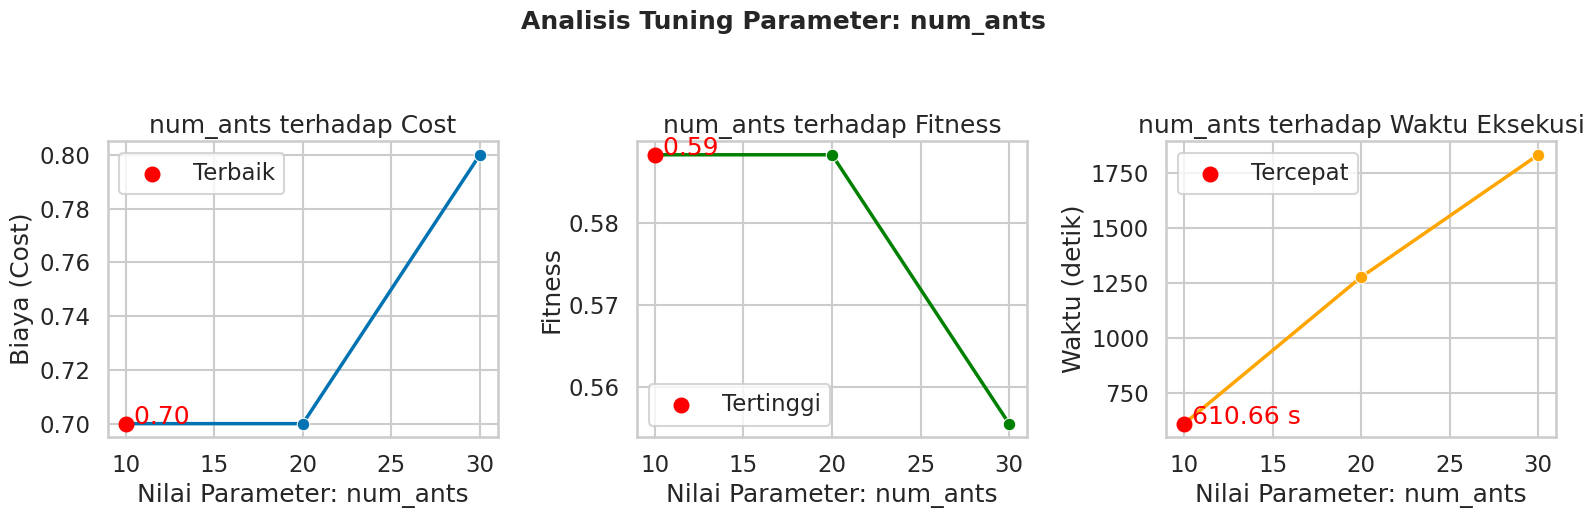

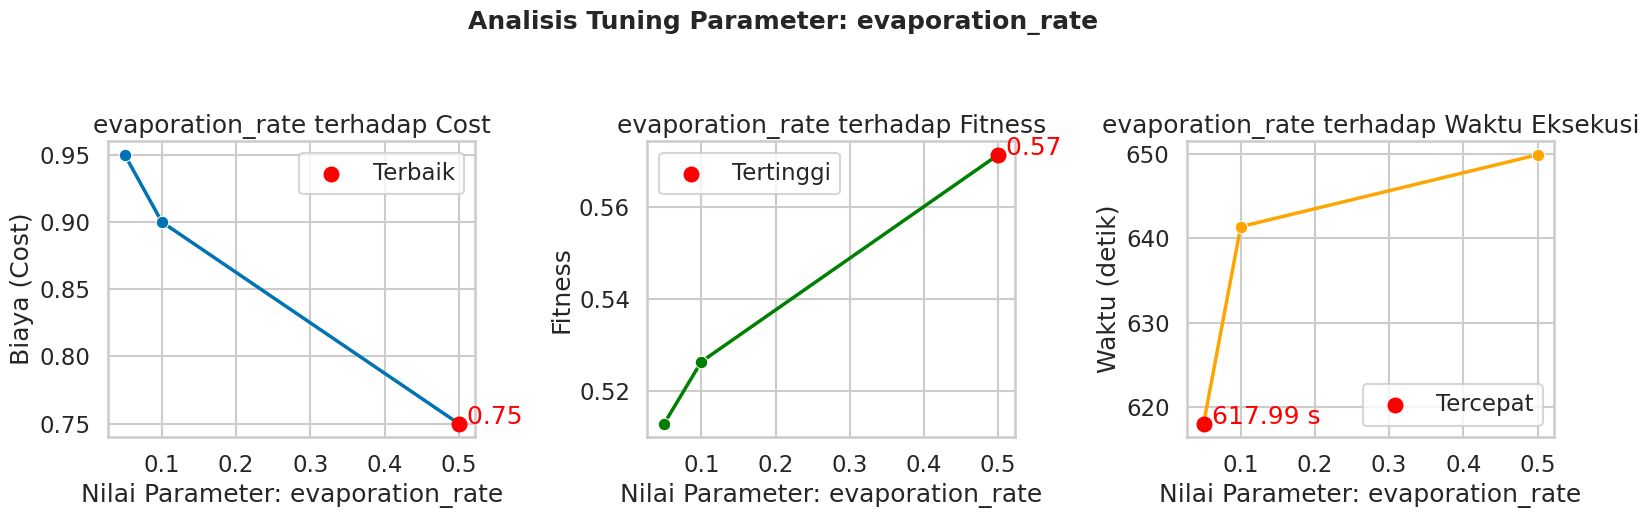

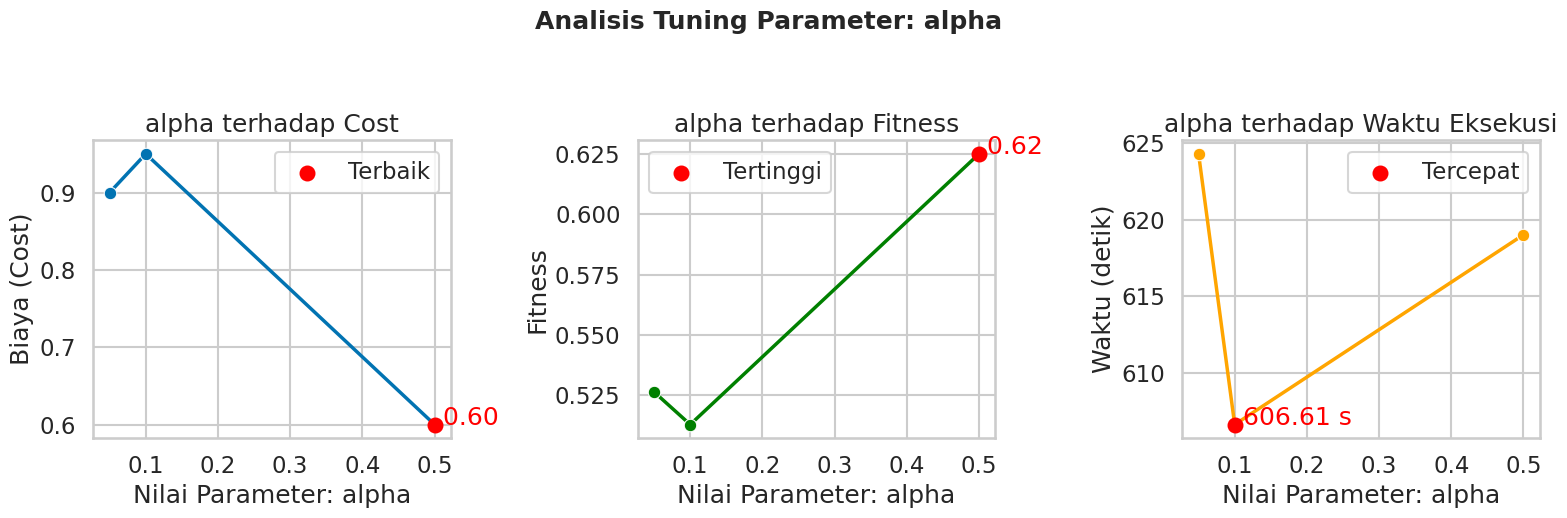

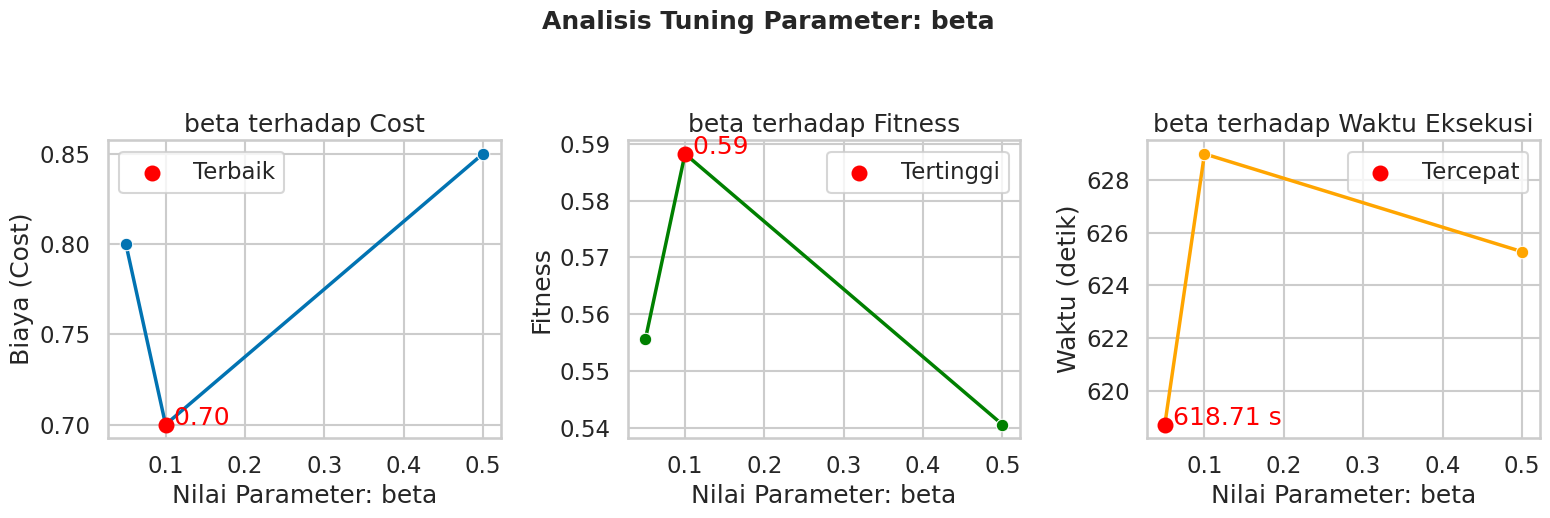

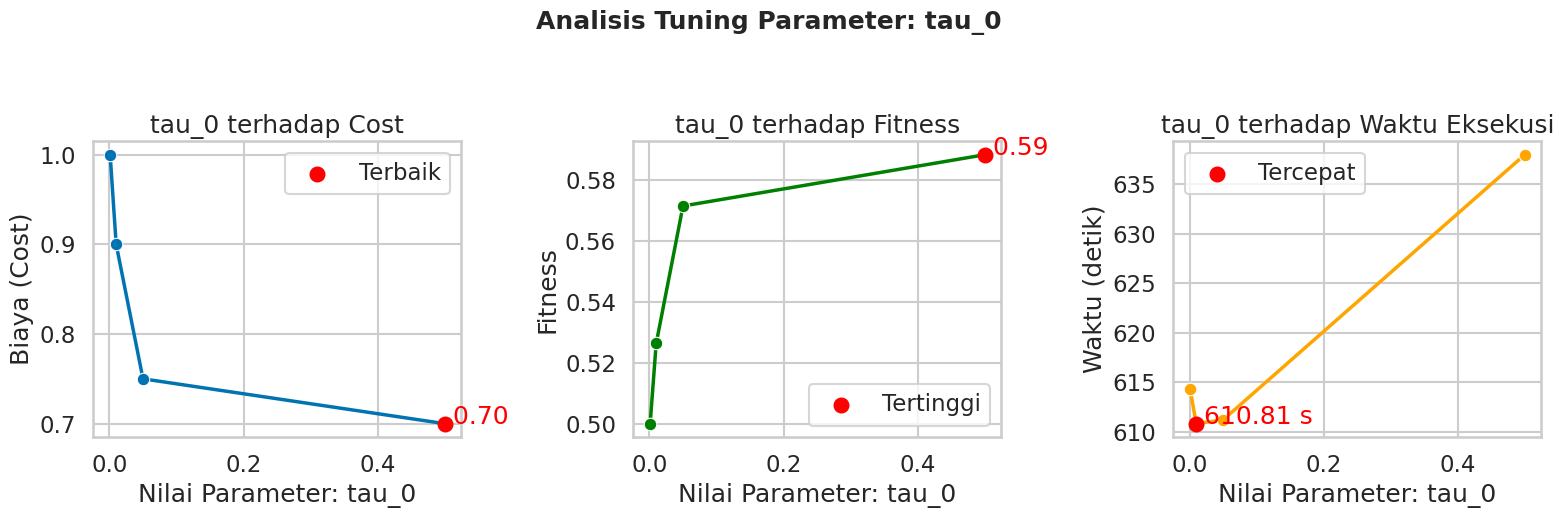

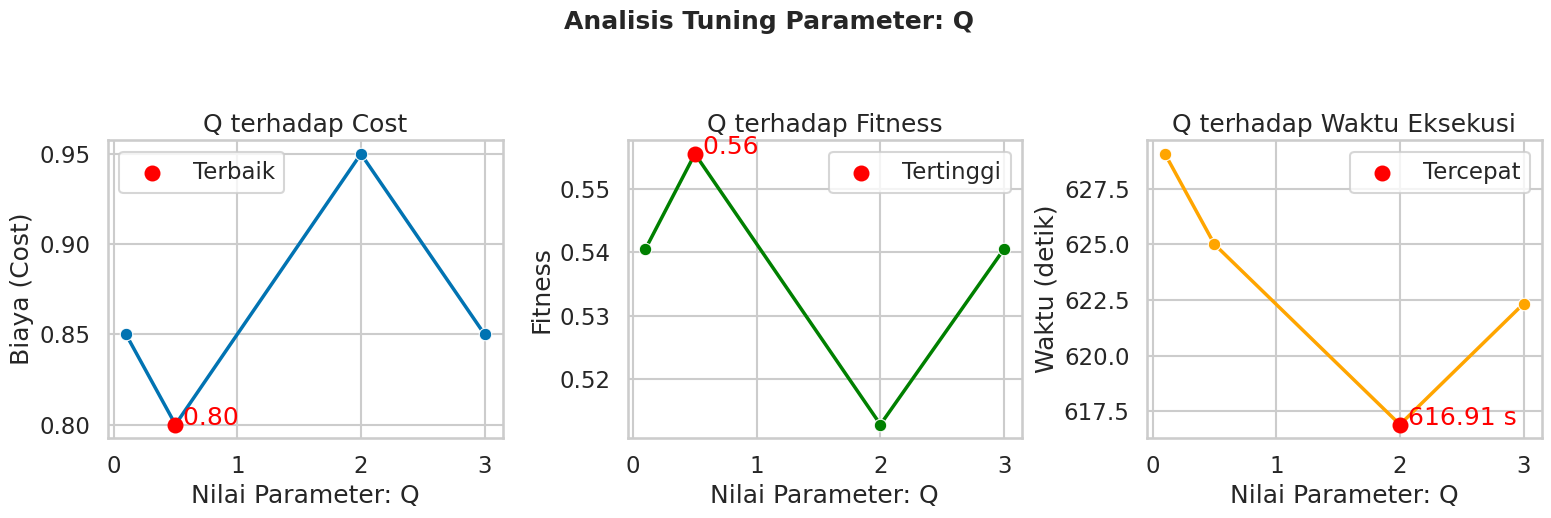

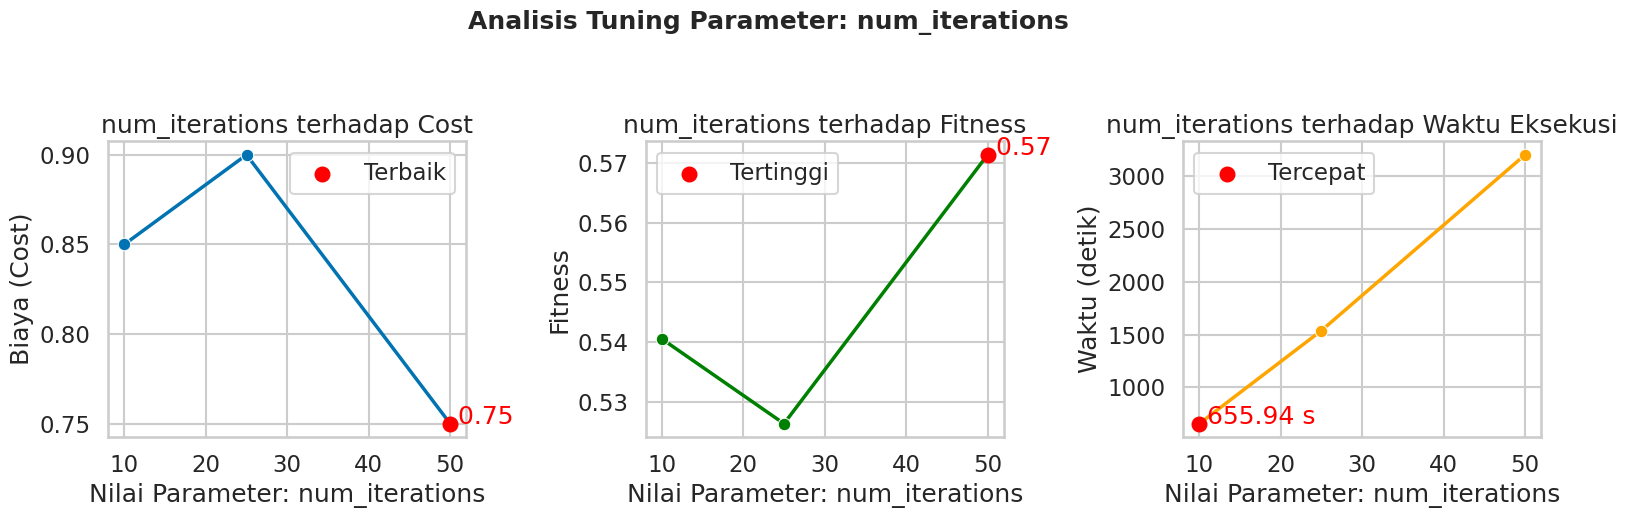

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid", context="talk", palette="colorblind")  # gaya yang ramah mata

for param_name, df in tuning_logs.items():
    plt.figure(figsize=(16, 5))
    # Mengubah 'value' menjadi 'Value' sesuai dengan nama kolom di DataFrame
    df_sorted = df.sort_values(by='Value')

    # --- Best Cost ---
    plt.subplot(1, 3, 1)
    sns.lineplot(x='Value', y='Cost', data=df_sorted, marker='o', linewidth=2.5)
    best_idx = df_sorted['Cost'].idxmin()
    best_val = df_sorted.loc[best_idx, 'Value']
    best_cost = df_sorted.loc[best_idx, 'Cost']
    plt.scatter(best_val, best_cost, color='red', s=100, zorder=5, label='Terbaik')
    plt.text(best_val, best_cost, f" {best_cost:.2f}", color='red')
    plt.title(f"{param_name} terhadap Cost")
    plt.xlabel(f"Nilai Parameter: {param_name}")
    plt.ylabel("Biaya (Cost)")
    plt.legend()

    # --- Best Fitness ---
    plt.subplot(1, 3, 2)
    sns.lineplot(x='Value', y='Fitness', data=df_sorted, marker='o', linewidth=2.5, color='green')
    best_idx = df_sorted['Fitness'].idxmax()
    best_val = df_sorted.loc[best_idx, 'Value']
    best_fitness = df_sorted.loc[best_idx, 'Fitness']
    plt.scatter(best_val, best_fitness, color='red', s=100, zorder=5, label='Tertinggi')
    plt.text(best_val, best_fitness, f" {best_fitness:.2f}", color='red')
    plt.title(f"{param_name} terhadap Fitness")
    plt.xlabel(f"Nilai Parameter: {param_name}")
    plt.ylabel("Fitness")
    plt.legend()

    # --- Execution Time ---
    plt.subplot(1, 3, 3)
    sns.lineplot(x='Value', y='Time', data=df_sorted, marker='o', linewidth=2.5, color='orange')
    best_idx = df_sorted['Time'].idxmin()
    best_val = df_sorted.loc[best_idx, 'Value']
    best_time = df_sorted.loc[best_idx, 'Time']
    plt.scatter(best_val, best_time, color='red', s=100, zorder=5, label='Tercepat')
    plt.text(best_val, best_time, f" {best_time:.2f} s", color='red')
    plt.title(f"{param_name} terhadap Waktu Eksekusi")
    plt.xlabel(f"Nilai Parameter: {param_name}")
    plt.ylabel("Waktu (detik)")
    plt.legend()

    plt.suptitle(f"Analisis Tuning Parameter: {param_name}", fontsize=18, fontweight='bold', y=1.05)
    plt.tight_layout()
    plt.show()

In [ ]:
from IPython.display import display, HTML
import re

# 1) Natural key function untuk sorting ruangan
def natural_key(s):
    return [int(tok) if tok.isdigit() else tok
            for tok in re.split(r'(\d+)', s)]

# Konversi sesi ke waktu
sesi_ke_waktu = {
    '1': '07:30–09:30',
    '2': '09:30–11:30',
    '3': '13:00–15:00',
    '4': '15:00–17:00'
}

# Siapkan jadwal_final
jadwal_final = best_solution.copy()
jadwal_final['Sesi'] = jadwal_final['Sesi'].astype(str)
jadwal_final['Waktu'] = jadwal_final['Sesi'].map(sesi_ke_waktu)

# Daftar unik
hari_list    = sorted(jadwal_final['Hari'].unique(), key=lambda x: int(x))
waktu_list   = list(sesi_ke_waktu.values())
ruangan_list = sorted(
    jadwal_final['Ruangan'].unique().astype(str).tolist(),
    key=natural_key
)

# Bangun HTML dengan styling
html = """
<style>
  table.jadwal {
    border-collapse: collapse;
    width: 100%;
    font-size: 13px;
    table-layout: fixed;
  }
  table.jadwal th, table.jadwal td {
    border: 1px solid #ccc;
    padding: 6px;
    text-align: left;
    vertical-align: top;
  }
  table.jadwal th {
    background-color: #2e7d32;
    color: white;
    text-align: center;
  }
  .slot {
    background-color: #fff5f5;
    color: #000;
    border-left: 4px solid #e53935;
    padding: 6px;
    border-radius: 4px;
    margin-bottom: 4px;
    font-size: 12px;
    font-weight: 500;
    line-height: 1.4;
  }
  .slot p {
    margin: 4px 0;
  }
</style>
<h3 style='color:#2e7d32;'>=== Jadwal Ujian Akhir Semester Terbaik ===</h3>
<table class='jadwal'>
  <thead>
    <tr><th>Waktu</th><th>Ruangan</th>"""
for hari in hari_list:
    html += f"<th>{hari}</th>"
html += "</tr></thead><tbody>"

# Isi body
for waktu in waktu_list:
    for ruangan in ruangan_list:
        html += f"<tr><td><b>{waktu}</b></td><td><b>{ruangan}</b></td>"
        for hari in hari_list:
            slot_data = jadwal_final[
                (jadwal_final['Hari'] == hari) &
                (jadwal_final['Waktu'] == waktu) &
                (jadwal_final['Ruangan'] == ruangan)
            ]
            if slot_data.empty:
                html += "<td></td>"
            else:
                cell = ""
                for _, row in slot_data.iterrows():
                    cell += f"""
                    <div class='slot'>
                      <p><b>MK:</b> {row['Mata Kuliah']}</p>
                      <p><b>Kelas:</b> {row['Kelas']}</p>
                      <p><b>Pengawas 1:</b> {row['Pengawas 1']}</p>
                      <p><b>Pengawas 2:</b> {row['Pengawas 2']}</p>
                    </div>
                    """
                html += f"<td>{cell}</td>"
        html += "</tr>"

html += "</tbody></table>"

# Render
display(HTML(html))

Waktu,Ruangan,1,2,3,4
07:30–09:30,F4.1,"MK: Bahasa Indonesia Kelas: N7G Pengawas 1: Yuita Arum Sari, S.Kom., M.Kom. Pengawas 2: Redy Gunawan Prasetya, S.Pt.",,"MK: Jaringan Nirkabel Kelas: E Pengawas 1: Eriq Muhammad Adams Jonemaro, S.T., M.Kom. Pengawas 2: Ahmad Khoirul","MK: Komputer Grafis Kelas: A Pengawas 1: Ir. Indriati, S.T., M.Kom. Pengawas 2: Yanuar Widiantono, S.Pd."
07:30–09:30,F4.2,"MK: Agama Hindu Kelas: N4A Pengawas 1: Prima Zulvarina, S.S., M.Pd. Pengawas 2: Rachmat Sidi Mawardi, S.Pd.","MK: Basis Data Kelas: C Pengawas 1: Donatus Maria Triman Adi Wibowo, Ph.d Pengawas 2: Lina Purbosari, S.Si","MK: Jaringan Nirkabel Kelas: D Pengawas 1: Ir. Dr.Eng. Herman Tolle, S.T., M.T. Pengawas 2: R. Siti Solihah Wahyuni Perdana, S.T.",
07:30–09:30,F4.3,"MK: Jaringan Saraf Tiruan Kelas: D Pengawas 1: Esa Kharisma Muhammad Nakti, S.S., M.Pd. Pengawas 2: Ghofar Ismail","MK: Deep Learning Kelas: C Pengawas 1: Dr. Candra Dewi, S.Kom., M.Sc. Pengawas 2: Yohanes Setiawan, STP.","MK: Jaringan Nirkabel Kelas: A Pengawas 1: Fariz Andri Bakhtiar, ST., M.Kom. Pengawas 2: Winda Sastra Dewi, S.AB. MK: Pengantar Keilmuan Komputer Kelas: B Pengawas 1: Dr. Eng. Novanto Yudistira, S.Kom., M.Sc. Pengawas 2: Fahrudin Rachmawan Saputra, S.E.","MK: Machine Learning Operations (MLOps) Kelas: B Pengawas 1: Rizal Setya Perdana, S.Kom., M.Kom., Ph.D. Pengawas 2: Redy Gunawan Prasetya, S.Pt."
07:30–09:30,F4.4,"MK: Pengantar Keilmuan Komputer Kelas: F Pengawas 1: Achmad Basuki, ST., MMG., Ph.D. Pengawas 2: Ghofar Ismail","MK: Kecerdasan Artifisial Kelas: A Pengawas 1: Mochamad Ighfir Sukardi, S.Pd., M.li., Pengawas 2: Ivan Yulfrian, S.Kom. MK: Basis Data Kelas: D Pengawas 1: Dr. Eng. Fitra Abdurrachman Bachtiar, S.T., M.Eng. Pengawas 2: R. Siti Solihah Wahyuni Perdana, S.T.","MK: Jaringan Nirkabel Kelas: B Pengawas 1: Yuita Arum Sari, S.Kom., M.Kom. Pengawas 2: Pambayun Wulan Utami, S.Si.","MK: Rekayasa Perangkat Lunak Kelas: M Pengawas 1: Puji Lestari, Pengawas 2: Hasta Budiratna, S.Sos."
07:30–09:30,F4.5,"MK: Jaringan Nirkabel Kelas: F Pengawas 1: Dr. Candra Dewi, S.Kom., M.Sc. Pengawas 2: Fransiscus Priharsono, S.Kom. MK: Pengantar Keilmuan Komputer Kelas: D Pengawas 1: Dr. Ir. Lailil Muflikhah, S.Kom., M.Sc. Pengawas 2: Arif Efendi","MK: Basis Data Kelas: A Pengawas 1: Rizal Setya Perdana, S.Kom., M.Kom., Ph.D. Pengawas 2: Djoko Irawan, S.E.",,
07:30–09:30,F4.6,"MK: Pengantar Keilmuan Komputer Kelas: A Pengawas 1: Fais Al Huda, S.Kom., M.Kom. Pengawas 2: Sativandi Putra, S.Kom., M.Kom.","MK: Basis Data Kelas: E Pengawas 1: Dr. Eng. Budi Darma Setiawan, S.Kom., M.Cs. Pengawas 2: Fahrudin Rachmawan Saputra, S.E.","MK: Jaringan Nirkabel Kelas: G Pengawas 1: Ir. Edy Santoso, S.Si., M.Kom. Pengawas 2: Pranoe Taterpiga, S.H.","MK: Statistika dan Teori Peluang Kelas: F Pengawas 1: Dr. Ir. Heru Nurwarsito, M.Kom. Pengawas 2: Fahrudin Rachmawan Saputra, S.E."
07:30–09:30,F4.7,,"MK: Kecerdasan Artifisial Kelas: F Pengawas 1: Dr. Eng. Novanto Yudistira, S.Kom., M.Sc. Pengawas 2: Nanda Galih Ardana, S.Kom. MK: Pola Perancangan Kelas: B Pengawas 1: Bayu Priyambadha, S.Kom., M.Kom., Ph.D. Pengawas 2: Ahmad Khoirul","MK: Jaringan Nirkabel Kelas: H Pengawas 1: Drs. Syamsul Arifin, M.Ag, Pengawas 2: Ahmad Zam Zam Almaqi","MK: Agama Katolik Kelas: N2A Pengawas 1: Ir. Agus Wahyu Widodo, S.T., M.Cs. Pengawas 2: Ignasia Henny Susanti, S.H. MK: Statistika dan Teori Peluang Kelas: D Pengawas 1: Ir. Dr.Eng. Herman Tolle, S.T., M.T. Pengawas 2: Nanda Galih Ardana, S.Kom."
07:30–09:30,F4.8,,"MK: Pola Perancangan Kelas: C Pengawas 1: Puji Lestari, Pengawas 2: Ahmad Nasichudin, S.E.","MK: Jaringan Nirkabel Kelas: C Pengawas 1: Drs. Syamsul Arifin, M.Ag, Pengawas 2: Anik Yuliani, S.E.","MK: Statistika dan Teori Peluang Kelas: A Pengawas 1: Dr. Eng. Fitra Abdurrachman Bachtiar, S.T., M.Eng. Pengawas 2: Broto Pamungkas, S.T."
07:30–09:30,F4.9,"MK: Pengembangan Aplikasi Perangkat Bergerak Kelas: G Pengawas 1: Khalid Rahman, S.Pd.I., M.Pd.I. Pengawas 2: Annisa Rachmasari, S.E.",,

In [ ]:
# Simpan ke file
with open("jadwal_final.html", "w", encoding="utf-8") as f:
    f.write(html)

In [ ]:
from google.colab import files
files.download("jadwal_final.html")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
total_expected = len(data_df)
total_scheduled = len(jadwal_final)
print(f"[ℹ️] Total kelas terjadwal: {total_scheduled} / {total_expected}")

[ℹ️] Total kelas terjadwal: 158 / 160
